In [121]:
# Import the library to mount Google Drive
from google.colab import drive

# Mount the Google Drive at /content/drive
drive.mount('/content/drive', force_remount=True)

# Verify by listing the files in the drive
%cd /content/drive/My\ Drive/Tugas_NLP

Mounted at /content/drive
/content/drive/My Drive/Tugas_NLP


In [271]:
%pip install newsapi-python newspaper3k dask lxml[html_clean] xgboost

In [297]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import string
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

import sklearn
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
import sklearn
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay

from newsapi import NewsApiClient
from newspaper import Article
import pandas as pd
import numpy as np

In [131]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
newsapi = NewsApiClient(api_key='928ebe1a4ae8458e898f50be625c1769')

In [407]:
df = pd.DataFrame()
arr_texts = []
arr_labels = []
labels = ['business', 'entertainment', 'health', 'science', 'sports', 'technology', 'general']

for label in labels:
  articles = newsapi.get_top_headlines(category=label,
                                          page_size=100,
                                          language='en')
  for news in articles['articles']:
    arr_texts.append(news['title'])
    arr_labels.append(label)

df = pd.DataFrame({'text': arr_texts, 'label': arr_labels})

df

,text,label
0,Stock futures are little changed as investors ...,business
1,GM is pulling the plug on its robotaxi efforts...,business
2,Adidas' German headquarters raided in connecti...,business
3,Alphabet Stock Jumps After Google Touts 'Break...,business
4,GameStop Swings to a Profit Despite Revenue Di...,business
...,...,...
305,"OxygenOS 15 arrives on OnePlus 11, bringing AI...",general
306,HPV testing preferred over Pap for cervical ca...,general
307,Israel bombs Syria and seizes territory as Net...,general
308,The Universe’s Expansion Rate Is Breaking Phys...,general


In [409]:
df.to_csv('news_topic_classification.csv')

In [152]:
df.loc[df["text"] == '[Removed]'] = np.nan

In [153]:
df["text"].isna().sum()

12

In [154]:
df = df.dropna()

In [155]:
df["text"].isna().sum()

0

In [156]:
# Print the duplicated data
df['text'].duplicated().sum()

16

In [157]:
df = df.drop_duplicates(subset=['text'])
df

,text,label
0,"Dow Jones Futures: Google, Tesla Strong But Pa...",business
1,Alphabet Stock Jumps After Google Touts 'Break...,business
2,Federal judge blocks largest supermarket merge...,business
3,GameStop Swings to a Profit Despite Revenue Di...,business
4,SMCI Stock: Supermicro Customers Staying Put W...,business
...,...,...
315,New Jersey state senator calls for 'limited st...,general
318,Traders are pretty sure of a Fed rate cut. Wha...,general
321,Israel bombs Syria and seizes territory as Net...,general
322,Trump wants to end birthright citizenship. Can...,general


In [158]:
df['label'].value_counts()

,count
label,
health,60
science,59
business,54
sports,52
technology,42
entertainment,21
general,13


In [159]:
from sklearn.model_selection import train_test_split

# get the locations
X = df['text']
y = df['label']

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [160]:
len(y_train)

240

In [161]:
len(y_test)

61

## Class Distribution

In [162]:
df_train = pd.DataFrame({'text': X_train, 'class': y_train})
df_test = pd.DataFrame({'text': X_test, 'class': y_test})

In [163]:
# Print the class distribution
df_train['class'].value_counts()

,count
class,
science,47
health,46
sports,44
business,44
technology,32
entertainment,17
general,10


In [164]:
# Print the class distribution
df_test['class'].value_counts()

,count
class,
health,14
science,12
business,10
technology,10
sports,8
entertainment,4
general,3


<Axes: xlabel='class', ylabel='count'>

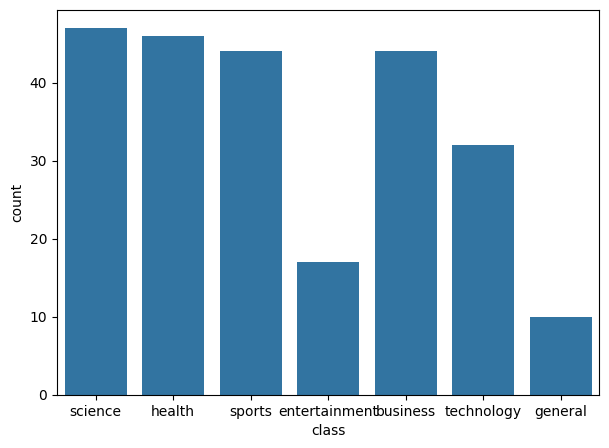

In [165]:
# Show the class distribution bar plot
fig = plt.figure(figsize=(7,5))
sns.countplot(x="class",data=df_train)

Text(0.5, 1.0, 'Distribution of categories')

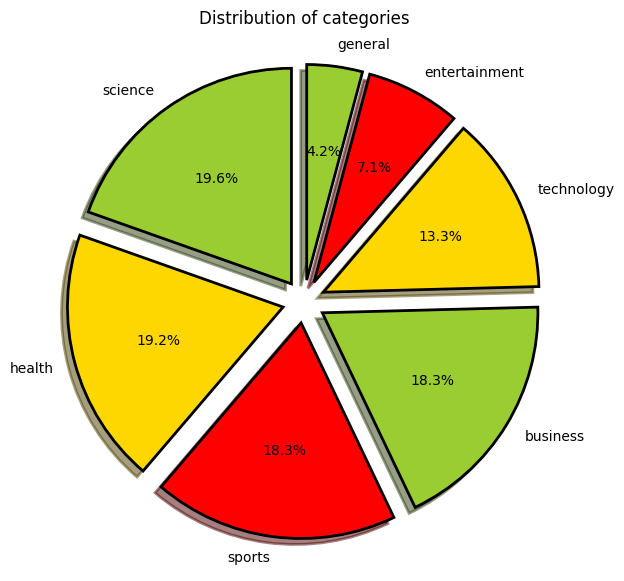

In [379]:
# Show the class distribution pie chart
fig = plt.figure(figsize=(7,7))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = df_train['class'].value_counts()
explode = (0.1,0.1,0.1,0.1,0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of categories')

# Pre-Processing Dataset

1. Lowering Case
2. Lemmatization/ Stemming
3. Remove Number
4. Remove Punctuation
5. Remove Stopword

## 1. Lowering Case

In [340]:
# Lowering all words
df_train['clean_text'] = df_train['text'].str.lower()

# Print the DataFrame
df_train.head()

,text,class,clean_text
191,Sun unleashes surprise X-class solar flare tri...,science,sun unleashes surprise x-class solar flare tri...
138,How to reduce cholesterol without statins: Thr...,health,how to reduce cholesterol without statins: thr...
201,Blue Jays reportedly trading for Guardians 2B ...,sports,blue jays reportedly trading for guardians 2b ...
75,Bird flu in California child linked to virus i...,health,bird flu in california child linked to virus i...
115,What are your questions about bird flu and mil...,health,what are your questions about bird flu and mil...


In [341]:
# Lowering all words
df_test['clean_text'] = df_test['text'].str.lower()

# Print the DataFrame
df_test.head()

,text,class,clean_text
184,Was This Half-Billion-Year-Old Wrinkled Sack W...,science,was this half-billion-year-old wrinkled sack w...
300,Syria's new transitional PM calls for stabilit...,general,syria's new transitional pm calls for stabilit...
235,Colts release unofficial depth chart for Week ...,sports,colts release unofficial depth chart for week ...
205,"Red Sox pursuing free agent Alex Bregman, but ...",sports,"red sox pursuing free agent alex bregman, but ..."
60,Timothée Chalamet Pre-Recorded Bob Dylan Vocal...,entertainment,timothée chalamet pre-recorded bob dylan vocal...


## 2. Lemmatization

In [342]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

# Lemmatizing all words
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: lemmatize_words(text))

# Print the DataFrame
df_train

,text,class,clean_text
191,Sun unleashes surprise X-class solar flare tri...,science,sun unleashes surprise x-class solar flare tri...
138,How to reduce cholesterol without statins: Thr...,health,how to reduce cholesterol without statins: thr...
201,Blue Jays reportedly trading for Guardians 2B ...,sports,blue jay reportedly trading for guardian 2b an...
75,Bird flu in California child linked to virus i...,health,bird flu in california child linked to virus i...
115,What are your questions about bird flu and mil...,health,what are your question about bird flu and milk...
...,...,...,...
195,NASA issues urgent alert: 5 giant asteroids on...,science,nasa issue urgent alert: 5 giant asteroid on a...
71,"Horoscope for Tuesday, December 10, 2024 - Chi...",entertainment,"horoscope for tuesday, december 10, 2024 - chi..."
110,CDC warns of deadly drug 100 times more potent...,health,cdc warns of deadly drug 100 time more potent ...
279,iPhone 17 Air vs iPhone 16 Pro: 5 reasons to w...,technology,iphone 17 air v iphone 16 pro: 5 reason to wai...


In [343]:
# Lemmatizing all words
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: lemmatize_words(text))

# Print the DataFrame
df_test

,text,class,clean_text
184,Was This Half-Billion-Year-Old Wrinkled Sack W...,science,wa this half-billion-year-old wrinkled sack wi...
300,Syria's new transitional PM calls for stabilit...,general,syria's new transitional pm call for stability...
235,Colts release unofficial depth chart for Week ...,sports,colt release unofficial depth chart for week 1...
205,"Red Sox pursuing free agent Alex Bregman, but ...",sports,"red sox pursuing free agent alex bregman, but ..."
60,Timothée Chalamet Pre-Recorded Bob Dylan Vocal...,entertainment,timothée chalamet pre-recorded bob dylan vocal...
...,...,...,...
241,How Yankees’ Refusal to Give Juan Soto a Luxur...,sports,how yankees’ refusal to give juan soto a luxur...
315,New Jersey state senator calls for 'limited st...,general,new jersey state senator call for 'limited sta...
290,"Google will give you another year, again, to m...",technology,"google will give you another year, again, to m..."
294,Marvel Rivals Success Has Players Debating Abo...,technology,marvel rival success ha player debating about ...


##2. Stemming

In [344]:
# Initialize stemmer
stemmer = PorterStemmer()

def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

# Stemming all words
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: stem_words(text))

# Print the DataFrame
df_train

,text,class,clean_text
191,Sun unleashes surprise X-class solar flare tri...,science,sun unleash surpris x-class solar flare trigge...
138,How to reduce cholesterol without statins: Thr...,health,how to reduc cholesterol without statins: thre...
201,Blue Jays reportedly trading for Guardians 2B ...,sports,blue jay reportedli trade for guardian 2b andr...
75,Bird flu in California child linked to virus i...,health,bird flu in california child link to viru in d...
115,What are your questions about bird flu and mil...,health,what are your question about bird flu and milk...
...,...,...,...
195,NASA issues urgent alert: 5 giant asteroids on...,science,nasa issu urgent alert: 5 giant asteroid on a ...
71,"Horoscope for Tuesday, December 10, 2024 - Chi...",entertainment,"horoscop for tuesday, decemb 10, 2024 - chicag..."
110,CDC warns of deadly drug 100 times more potent...,health,cdc warn of deadli drug 100 time more potent t...
279,iPhone 17 Air vs iPhone 16 Pro: 5 reasons to w...,technology,iphon 17 air v iphon 16 pro: 5 reason to wait ...


In [345]:
# Stemming all words
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: stem_words(text))

# Print the DataFrame
df_test

,text,class,clean_text
184,Was This Half-Billion-Year-Old Wrinkled Sack W...,science,wa thi half-billion-year-old wrinkl sack with ...
300,Syria's new transitional PM calls for stabilit...,general,syria' new transit pm call for stabil and calm...
235,Colts release unofficial depth chart for Week ...,sports,colt releas unoffici depth chart for week 15 g...
205,"Red Sox pursuing free agent Alex Bregman, but ...",sports,"red sox pursu free agent alex bregman, but int..."
60,Timothée Chalamet Pre-Recorded Bob Dylan Vocal...,entertainment,timothé chalamet pre-record bob dylan vocal fo...
...,...,...,...
241,How Yankees’ Refusal to Give Juan Soto a Luxur...,sports,how yankees’ refus to give juan soto a luxuri ...
315,New Jersey state senator calls for 'limited st...,general,new jersey state senat call for 'limit state o...
290,"Google will give you another year, again, to m...",technology,"googl will give you anoth year, again, to make..."
294,Marvel Rivals Success Has Players Debating Abo...,technology,marvel rival success ha player debat about con...


## 3. Remove Number

In [346]:
# Remove number
def remove_number(string):
    return ''.join(c for c in string if not c.isdigit())

df_train['clean_text'] = df_train['clean_text'].apply(lambda text: remove_number(text))

# Print the DataFrame
df_train.head()

,text,class,clean_text
191,Sun unleashes surprise X-class solar flare tri...,science,sun unleash surpris x-class solar flare trigge...
138,How to reduce cholesterol without statins: Thr...,health,how to reduc cholesterol without statins: thre...
201,Blue Jays reportedly trading for Guardians 2B ...,sports,blue jay reportedli trade for guardian b andré...
75,Bird flu in California child linked to virus i...,health,bird flu in california child link to viru in d...
115,What are your questions about bird flu and mil...,health,what are your question about bird flu and milk...


In [347]:
# Remove number
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: remove_number(text))

# Print the DataFrame
df_test.head()

,text,class,clean_text
184,Was This Half-Billion-Year-Old Wrinkled Sack W...,science,wa thi half-billion-year-old wrinkl sack with ...
300,Syria's new transitional PM calls for stabilit...,general,syria' new transit pm call for stabil and calm...
235,Colts release unofficial depth chart for Week ...,sports,colt releas unoffici depth chart for week gam...
205,"Red Sox pursuing free agent Alex Bregman, but ...",sports,"red sox pursu free agent alex bregman, but int..."
60,Timothée Chalamet Pre-Recorded Bob Dylan Vocal...,entertainment,timothé chalamet pre-record bob dylan vocal fo...


## 4. Remove Punctuation

In [348]:
# Remove punctuation
PUNCT_TO_REMOVE = string.punctuation + '“' + '”' + '’' + '”' + '…' + '‘' + '–' + '—'
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df_train['clean_text'] = df_train['clean_text'].apply(lambda text: remove_punctuation(text))

# Print the DataFrame
df_train

,text,class,clean_text
191,Sun unleashes surprise X-class solar flare tri...,science,sun unleash surpris xclass solar flare trigger...
138,How to reduce cholesterol without statins: Thr...,health,how to reduc cholesterol without statins three...
201,Blue Jays reportedly trading for Guardians 2B ...,sports,blue jay reportedli trade for guardian b andré...
75,Bird flu in California child linked to virus i...,health,bird flu in california child link to viru in d...
115,What are your questions about bird flu and mil...,health,what are your question about bird flu and milk...
...,...,...,...
195,NASA issues urgent alert: 5 giant asteroids on...,science,nasa issu urgent alert giant asteroid on a co...
71,"Horoscope for Tuesday, December 10, 2024 - Chi...",entertainment,horoscop for tuesday decemb chicago suntim
110,CDC warns of deadly drug 100 times more potent...,health,cdc warn of deadli drug time more potent than...
279,iPhone 17 Air vs iPhone 16 Pro: 5 reasons to w...,technology,iphon air v iphon pro reason to wait for th...


In [349]:
# Remove punctuation
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: remove_punctuation(text))

# Print the DataFrame
df_test

,text,class,clean_text
184,Was This Half-Billion-Year-Old Wrinkled Sack W...,science,wa thi halfbillionyearold wrinkl sack with no ...
300,Syria's new transitional PM calls for stabilit...,general,syria new transit pm call for stabil and calm ...
235,Colts release unofficial depth chart for Week ...,sports,colt releas unoffici depth chart for week gam...
205,"Red Sox pursuing free agent Alex Bregman, but ...",sports,red sox pursu free agent alex bregman but inte...
60,Timothée Chalamet Pre-Recorded Bob Dylan Vocal...,entertainment,timothé chalamet prerecord bob dylan vocal for...
...,...,...,...
241,How Yankees’ Refusal to Give Juan Soto a Luxur...,sports,how yankees refus to give juan soto a luxuri s...
315,New Jersey state senator calls for 'limited st...,general,new jersey state senat call for limit state of...
290,"Google will give you another year, again, to m...",technology,googl will give you anoth year again to make t...
294,Marvel Rivals Success Has Players Debating Abo...,technology,marvel rival success ha player debat about con...


##5. Remove Stopword

In [350]:
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df_train['clean_text'] = df_train['clean_text'].apply(lambda text: remove_stopwords(text))
df_train

,text,class,clean_text
191,Sun unleashes surprise X-class solar flare tri...,science,sun unleash surpris xclass solar flare trigger...
138,How to reduce cholesterol without statins: Thr...,health,reduc cholesterol without statins three nonpha...
201,Blue Jays reportedly trading for Guardians 2B ...,sports,blue jay reportedli trade guardian b andré gim...
75,Bird flu in California child linked to virus i...,health,bird flu california child link viru dairi cows...
115,What are your questions about bird flu and mil...,health,question bird flu milk cnn
...,...,...,...
195,NASA issues urgent alert: 5 giant asteroids on...,science,nasa issu urgent alert giant asteroid collis c...
71,"Horoscope for Tuesday, December 10, 2024 - Chi...",entertainment,horoscop tuesday decemb chicago suntim
110,CDC warns of deadly drug 100 times more potent...,health,cdc warn deadli drug time potent fentanyl over...
279,iPhone 17 Air vs iPhone 16 Pro: 5 reasons to w...,technology,iphon air v iphon pro reason wait new iphon to...


In [351]:
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: remove_stopwords(text))
df_test

,text,class,clean_text
184,Was This Half-Billion-Year-Old Wrinkled Sack W...,science,wa thi halfbillionyearold wrinkl sack anus pre...
300,Syria's new transitional PM calls for stabilit...,general,syria new transit pm call stabil calm bbccom
235,Colts release unofficial depth chart for Week ...,sports,colt releas unoffici depth chart week game vs ...
205,"Red Sox pursuing free agent Alex Bregman, but ...",sports,red sox pursu free agent alex bregman intern d...
60,Timothée Chalamet Pre-Recorded Bob Dylan Vocal...,entertainment,timothé chalamet prerecord bob dylan vocal com...
...,...,...,...
241,How Yankees’ Refusal to Give Juan Soto a Luxur...,sports,yankees refus give juan soto luxuri suit help ...
315,New Jersey state senator calls for 'limited st...,general,new jersey state senat call limit state emerge...
290,"Google will give you another year, again, to m...",technology,googl give anoth year make stadium control use...
294,Marvel Rivals Success Has Players Debating Abo...,technology,marvel rival success ha player debat concord p...


# Embedding

In [352]:
import numpy as np

# Dictionary to map words to their index in the GloVe embedding
glove_word_to_index = {}

# List to store the GloVe word embeddings
glove_word_embedding = []

# Open the GloVe embedding file and read its contents
with open('glove.6B.50d.txt', 'r', encoding='utf-8') as f:  # Specify encoding
    for line in f:
        word = line.split()[0]
        embedding = [float(value) for value in line.split()[1:]]

        glove_word_to_index[word] = len(glove_word_to_index)

        glove_word_embedding.append(embedding)

# Function to get the GloVe embedding for a given word
def glove_embed_word(word):
    try:
        return glove_word_embedding[glove_word_to_index[word]]
    except KeyError:
        return np.zeros(len(glove_word_embedding[0]))


# Training Functions

# Training Initial Model

1. Multinomial/Gaussian Naive Bayes
2. Logistic Regression
3. Random Forest
4. XGBoost
5. Support Vector Machine (Linear Kernel)
6. Support Vector Machine (RBF Kernel)

In [353]:
# Initialize Experiment Result DataFrame
df_result = pd.DataFrame(columns=['model', 'preprocessing', 'feature_extraction', 'test_avg_precision', 'test_avg_recall', 'test_avg_f1', 'test_acc'])

In [354]:
# Initialize label encoder
label_encoder = sklearn.preprocessing.LabelEncoder()

# Encode labels in column class
label_encoder.fit(y_train)

LabelEncoder()

In [355]:
def preprocess_other(df, embed_word):
    # TODO: Implement the other model preprocessing
    # Manually pad the sequences
    X = np.array(df['clean_text'])

    # Convert sentiment labels to numpy array
    y = df['class'].values

    # Embed the text data using the precomputed word embedding matrix
    embedding_dim = 50
    X_embedded = np.zeros((X.shape[0], embedding_dim))
    for i, seq in enumerate(X):
        doc_embedded = np.zeros((len(seq), embedding_dim))
        for j, word in enumerate(seq):
            if word != '0':
                doc_embedded[j] = embed_word(word)
        X_embedded[i] = doc_embedded.mean(axis=0)
    return X_embedded, y

# Generalized training function
def train_model(model_name, df, embed_word):
    X_embedded, y = preprocess_other(df, embed_word)
    print(X_embedded.shape)
    model = model_map[model_name]
    if model_name == 'xgboost':
        # Encode labels in column class
        y = label_encoder.transform(y)
    model.fit(X_embedded, y)

# Training & Evaluating (Word2Vec)

In [356]:
feature_extraction = 'word2vec'

In [357]:
def evaluate_model(model_name, df_test, embed_function, df_result):
    X_test_embedded, _ = preprocess_other(df_test, embed_function)
    print(X_test_embedded.shape)

    model = model_map[model_name]
    y_pred = model.predict(X_test_embedded)

    if model_name == 'xgboost':
      y_pred = label_encoder.inverse_transform(y_pred)

    # # convert true labels to binary
    y_true = df_test['class']

    # use classification_report from sklearn
    report = classification_report(y_true, y_pred)
    print(f'Classification Report for {model_name}:')
    print(report)

    test_acc = accuracy_score(y_true, y_pred)
    test_p, test_r, test_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

    data = {}
    data['model'] = model_name
    data['preprocessing'] = preprocessing
    data['feature_extraction'] = feature_extraction
    data['test_avg_precision'] = round(test_p, 2)
    data['test_avg_recall'] = round(test_r, 2)
    data['test_avg_f1'] = round(test_f1, 2)
    data['test_acc'] = round(test_acc, 2)
    df_result = pd.concat([df_result, pd.DataFrame([data])], ignore_index=True)

    return df_result

In [358]:
#with lemmat
preprocessing = "lowering-lemmatization-number-punctuation-stopword"

model_map = {}

gnb_model = GaussianNB()
# Add the Gaussian Naive Bayes model to the model_map
model_map['gaussian-naive-bayes'] = gnb_model

rf_model = RandomForestClassifier()
# Add the random forest model to the model_map
model_map['random-forest'] = rf_model

# Define the logistic regression model
logr_model = linear_model.LogisticRegression()
# Add the random forest model to the model_map
model_map['logistic-regression'] = logr_model

xgb_model = XGBClassifier()
# Add the random forest model to the model_map
model_map['xgboost'] = xgb_model

svml_model = SVC(kernel='linear')
# Add the random forest model to the model_map
model_map['svm-linear'] = svml_model

svmr_model = SVC(kernel='rbf')
# Add the random forest model to the model_map
model_map['svm-rbf'] = svmr_model

train_model('gaussian-naive-bayes', df_train, glove_embed_word)
train_model('random-forest', df_train, glove_embed_word)
train_model('logistic-regression', df_train, glove_embed_word)
train_model('xgboost', df_train, glove_embed_word)
train_model('svm-linear', df_train, glove_embed_word)
train_model('svm-rbf', df_train, glove_embed_word)

df_result = evaluate_model('gaussian-naive-bayes', df_test, glove_embed_word, df_result)
df_result = evaluate_model('random-forest', df_test, glove_embed_word, df_result)
df_result = evaluate_model('logistic-regression', df_test, glove_embed_word, df_result)
df_result = evaluate_model('xgboost', df_test, glove_embed_word, df_result)
df_result = evaluate_model('svm-linear', df_test, glove_embed_word, df_result)
df_result = evaluate_model('svm-rbf', df_test, glove_embed_word, df_result)

(240, 50)
(240, 50)
(240, 50)
(240, 50)
(240, 50)
(240, 50)
(61, 50)
Classification Report for gaussian-naive-bayes:
               precision    recall  f1-score   support

     business       0.25      0.20      0.22        10
entertainment       0.00      0.00      0.00         4
      general       0.00      0.00      0.00         3
       health       0.17      0.07      0.10        14
      science       0.40      0.50      0.44        12
       sports       0.40      0.50      0.44         8
   technology       0.50      0.40      0.44        10

     accuracy                           0.28        61
    macro avg       0.25      0.24      0.24        61
 weighted avg       0.29      0.28      0.28        61

(61, 50)
Classification Report for random-forest:
               precision    recall  f1-score   support

     business       0.07      0.10      0.08        10
entertainment       0.00      0.00      0.00         4
      general       0.00      0.00      0.00         3
    

<ipython-input-357-4e73bb0d4952>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result = pd.concat([df_result, pd.DataFrame([data])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

In [359]:
#with stemmer
preprocessing = "lowering-stemmer-number-punctuation-stopword"

# Lowering all words
df_train['clean_text'] = df_train['text'].str.lower()
df_test['clean_text'] = df_test['text'].str.lower()

# Stemming all words
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: stem_words(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: stem_words(text))

# Remove number
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: remove_number(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: remove_number(text))

# Remove punctuation
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: remove_punctuation(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: remove_punctuation(text))

# Remove stopwords
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: remove_stopwords(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: remove_stopwords(text))

model_map = {}

gnb_model = GaussianNB()
# Add the Gaussian Naive Bayes model to the model_map
model_map['gaussian-naive-bayes'] = gnb_model

rf_model = RandomForestClassifier()
# Add the random forest model to the model_map
model_map['random-forest'] = rf_model

# Define the logistic regression model
logr_model = linear_model.LogisticRegression()
# Add the random forest model to the model_map
model_map['logistic-regression'] = logr_model

xgb_model = XGBClassifier()
# Add the random forest model to the model_map
model_map['xgboost'] = xgb_model

svml_model = SVC(kernel='linear')
# Add the random forest model to the model_map
model_map['svm-linear'] = svml_model

svmr_model = SVC(kernel='rbf')
# Add the random forest model to the model_map
model_map['svm-rbf'] = svmr_model

train_model('gaussian-naive-bayes', df_train, glove_embed_word)
train_model('random-forest', df_train, glove_embed_word)
train_model('logistic-regression', df_train, glove_embed_word)
train_model('xgboost', df_train, glove_embed_word)
train_model('svm-linear', df_train, glove_embed_word)
train_model('svm-rbf', df_train, glove_embed_word)

df_result = evaluate_model('gaussian-naive-bayes', df_test, glove_embed_word, df_result)
df_result = evaluate_model('random-forest', df_test, glove_embed_word, df_result)
df_result = evaluate_model('logistic-regression', df_test, glove_embed_word, df_result)
df_result = evaluate_model('xgboost', df_test, glove_embed_word, df_result)
df_result = evaluate_model('svm-linear', df_test, glove_embed_word, df_result)
df_result = evaluate_model('svm-rbf', df_test, glove_embed_word, df_result)

(240, 50)
(240, 50)
(240, 50)
(240, 50)
(240, 50)
(240, 50)
(61, 50)
Classification Report for gaussian-naive-bayes:
               precision    recall  f1-score   support

     business       0.25      0.20      0.22        10
entertainment       0.00      0.00      0.00         4
      general       0.00      0.00      0.00         3
       health       0.17      0.07      0.10        14
      science       0.43      0.50      0.46        12
       sports       0.40      0.50      0.44         8
   technology       0.50      0.40      0.44        10

     accuracy                           0.28        61
    macro avg       0.25      0.24      0.24        61
 weighted avg       0.30      0.28      0.28        61

(61, 50)
Classification Report for random-forest:
               precision    recall  f1-score   support

     business       0.21      0.30      0.25        10
entertainment       0.00      0.00      0.00         4
      general       0.00      0.00      0.00         3
    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [360]:
#no lemmat
preprocessing = "lowering-number-punctuation-stopword"

# Lowering all words
df_train['clean_text'] = df_train['text'].str.lower()
df_test['clean_text'] = df_test['text'].str.lower()

# Remove number
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: remove_number(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: remove_number(text))

# Remove punctuation
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: remove_punctuation(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: remove_punctuation(text))

# Remove stopwords
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: remove_stopwords(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: remove_stopwords(text))

model_map = {}

gnb_model = GaussianNB()
# Add the Gaussian Naive Bayes model to the model_map
model_map['gaussian-naive-bayes'] = gnb_model

rf_model = RandomForestClassifier()
# Add the random forest model to the model_map
model_map['random-forest'] = rf_model

# Define the logistic regression model
logr_model = linear_model.LogisticRegression()
# Add the random forest model to the model_map
model_map['logistic-regression'] = logr_model

xgb_model = XGBClassifier()
# Add the random forest model to the model_map
model_map['xgboost'] = xgb_model

svml_model = SVC(kernel='linear')
# Add the random forest model to the model_map
model_map['svm-linear'] = svml_model

svmr_model = SVC(kernel='rbf')
# Add the random forest model to the model_map
model_map['svm-rbf'] = svmr_model

train_model('gaussian-naive-bayes', df_train, glove_embed_word)
train_model('random-forest', df_train, glove_embed_word)
train_model('logistic-regression', df_train, glove_embed_word)
train_model('xgboost', df_train, glove_embed_word)
train_model('svm-linear', df_train, glove_embed_word)
train_model('svm-rbf', df_train, glove_embed_word)

df_result = evaluate_model('gaussian-naive-bayes', df_test, glove_embed_word, df_result)
df_result = evaluate_model('random-forest', df_test, glove_embed_word, df_result)
df_result = evaluate_model('logistic-regression', df_test, glove_embed_word, df_result)
df_result = evaluate_model('xgboost', df_test, glove_embed_word, df_result)
df_result = evaluate_model('svm-linear', df_test, glove_embed_word, df_result)
df_result = evaluate_model('svm-rbf', df_test, glove_embed_word, df_result)

(240, 50)
(240, 50)
(240, 50)
(240, 50)
(240, 50)
(240, 50)
(61, 50)
Classification Report for gaussian-naive-bayes:
               precision    recall  f1-score   support

     business       0.20      0.10      0.13        10
entertainment       0.09      0.25      0.13         4
      general       0.00      0.00      0.00         3
       health       0.40      0.29      0.33        14
      science       0.80      0.33      0.47        12
       sports       0.31      0.50      0.38         8
   technology       0.17      0.20      0.18        10

     accuracy                           0.26        61
    macro avg       0.28      0.24      0.23        61
 weighted avg       0.36      0.26      0.28        61

(61, 50)
Classification Report for random-forest:
               precision    recall  f1-score   support

     business       0.08      0.10      0.09        10
entertainment       0.00      0.00      0.00         4
      general       0.00      0.00      0.00         3
    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [361]:
#no stop with lemmat
preprocessing = "lowering-lemmatization-number-punctuation"

# Lowering all words
df_train['clean_text'] = df_train['text'].str.lower()
df_test['clean_text'] = df_test['text'].str.lower()

# Lemmatizing all words
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: lemmatize_words(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: lemmatize_words(text))

# Remove number
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: remove_number(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: remove_number(text))

# Remove punctuation
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: remove_punctuation(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: remove_punctuation(text))

model_map = {}

gnb_model = GaussianNB()
# Add the Gaussian Naive Bayes model to the model_map
model_map['gaussian-naive-bayes'] = gnb_model

rf_model = RandomForestClassifier()
# Add the random forest model to the model_map
model_map['random-forest'] = rf_model

# Define the logistic regression model
logr_model = linear_model.LogisticRegression()
# Add the random forest model to the model_map
model_map['logistic-regression'] = logr_model

xgb_model = XGBClassifier()
# Add the random forest model to the model_map
model_map['xgboost'] = xgb_model

svml_model = SVC(kernel='linear')
# Add the random forest model to the model_map
model_map['svm-linear'] = svml_model

svmr_model = SVC(kernel='rbf')
# Add the random forest model to the model_map
model_map['svm-rbf'] = svmr_model

train_model('gaussian-naive-bayes', df_train, glove_embed_word)
train_model('random-forest', df_train, glove_embed_word)
train_model('logistic-regression', df_train, glove_embed_word)
train_model('xgboost', df_train, glove_embed_word)
train_model('svm-linear', df_train, glove_embed_word)
train_model('svm-rbf', df_train, glove_embed_word)

df_result = evaluate_model('gaussian-naive-bayes', df_test, glove_embed_word, df_result)
df_result = evaluate_model('random-forest', df_test, glove_embed_word, df_result)
df_result = evaluate_model('logistic-regression', df_test, glove_embed_word, df_result)
df_result = evaluate_model('xgboost', df_test, glove_embed_word, df_result)
df_result = evaluate_model('svm-linear', df_test, glove_embed_word, df_result)
df_result = evaluate_model('svm-rbf', df_test, glove_embed_word, df_result)

(240, 50)
(240, 50)
(240, 50)
(240, 50)
(240, 50)
(240, 50)
(61, 50)
Classification Report for gaussian-naive-bayes:
               precision    recall  f1-score   support

     business       0.33      0.10      0.15        10
entertainment       0.00      0.00      0.00         4
      general       0.00      0.00      0.00         3
       health       0.17      0.14      0.15        14
      science       0.38      0.42      0.40        12
       sports       0.36      0.50      0.42         8
   technology       0.25      0.20      0.22        10

     accuracy                           0.23        61
    macro avg       0.21      0.19      0.19        61
 weighted avg       0.26      0.23      0.23        61

(61, 50)
Classification Report for random-forest:
               precision    recall  f1-score   support

     business       0.18      0.20      0.19        10
entertainment       0.00      0.00      0.00         4
      general       0.00      0.00      0.00         3
    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Classification Report for xgboost:
               precision    recall  f1-score   support

     business       0.23      0.30      0.26        10
entertainment       0.50      0.25      0.33         4
      general       0.00      0.00      0.00         3
       health       0.40      0.29      0.33        14
      science       0.47      0.58      0.52        12
       sports       0.29      0.50      0.36         8
   technology       0.33      0.20      0.25        10

     accuracy                           0.34        61
    macro avg       0.32      0.30      0.29        61
 weighted avg       0.35      0.34      0.33        61

(61, 50)
Classification Report for svm-linear:
               precision    recall  f1-score   support

     business       0.00      0.00      0.00        10
entertainment       0.00      0.00      0.00         4
      general       0.00      0.00      0.00         3
       health       0.36      0.36      0.36        14
      science       0.25      0.67

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [362]:
#no stop with stemmer
preprocessing = "lowering-stemmer-number-punctuation"

# Lowering all words
df_train['clean_text'] = df_train['text'].str.lower()
df_test['clean_text'] = df_test['text'].str.lower()

# Stemming all words
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: stem_words(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: stem_words(text))

# Remove number
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: remove_number(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: remove_number(text))

# Remove punctuation
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: remove_punctuation(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: remove_punctuation(text))

model_map = {}

gnb_model = GaussianNB()
# Add the Gaussian Naive Bayes model to the model_map
model_map['gaussian-naive-bayes'] = gnb_model

rf_model = RandomForestClassifier()
# Add the random forest model to the model_map
model_map['random-forest'] = rf_model

# Define the logistic regression model
logr_model = linear_model.LogisticRegression()
# Add the random forest model to the model_map
model_map['logistic-regression'] = logr_model

xgb_model = XGBClassifier()
# Add the random forest model to the model_map
model_map['xgboost'] = xgb_model

svml_model = SVC(kernel='linear')
# Add the random forest model to the model_map
model_map['svm-linear'] = svml_model

svmr_model = SVC(kernel='rbf')
# Add the random forest model to the model_map
model_map['svm-rbf'] = svmr_model

train_model('gaussian-naive-bayes', df_train, glove_embed_word)
train_model('random-forest', df_train, glove_embed_word)
train_model('logistic-regression', df_train, glove_embed_word)
train_model('xgboost', df_train, glove_embed_word)
train_model('svm-linear', df_train, glove_embed_word)
train_model('svm-rbf', df_train, glove_embed_word)

df_result = evaluate_model('gaussian-naive-bayes', df_test, glove_embed_word, df_result)
df_result = evaluate_model('random-forest', df_test, glove_embed_word, df_result)
df_result = evaluate_model('logistic-regression', df_test, glove_embed_word, df_result)
df_result = evaluate_model('xgboost', df_test, glove_embed_word, df_result)
df_result = evaluate_model('svm-linear', df_test, glove_embed_word, df_result)
df_result = evaluate_model('svm-rbf', df_test, glove_embed_word, df_result)

(240, 50)
(240, 50)
(240, 50)
(240, 50)
(240, 50)
(240, 50)
(61, 50)
Classification Report for gaussian-naive-bayes:
               precision    recall  f1-score   support

     business       0.20      0.10      0.13        10
entertainment       0.00      0.00      0.00         4
      general       0.00      0.00      0.00         3
       health       0.29      0.14      0.19        14
      science       0.46      0.50      0.48        12
       sports       0.25      0.50      0.33         8
   technology       0.44      0.40      0.42        10

     accuracy                           0.28        61
    macro avg       0.23      0.23      0.22        61
 weighted avg       0.29      0.28      0.27        61

(61, 50)
Classification Report for random-forest:
               precision    recall  f1-score   support

     business       0.18      0.20      0.19        10
entertainment       0.00      0.00      0.00         4
      general       0.00      0.00      0.00         3
    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

(61, 50)
Classification Report for svm-linear:
               precision    recall  f1-score   support

     business       0.00      0.00      0.00        10
entertainment       0.00      0.00      0.00         4
      general       0.00      0.00      0.00         3
       health       0.40      0.29      0.33        14
      science       0.24      0.67      0.35        12
       sports       0.24      0.50      0.32         8
   technology       0.00      0.00      0.00        10

     accuracy                           0.26        61
    macro avg       0.12      0.21      0.14        61
 weighted avg       0.17      0.26      0.19        61

(61, 50)
Classification Report for svm-rbf:
               precision    recall  f1-score   support

     business       0.00      0.00      0.00        10
entertainment       0.00      0.00      0.00         4
      general       0.00      0.00      0.00         3
       health       0.00      0.00      0.00        14
      science       0.20 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [363]:
#no stop no lemma
preprocessing = "lowering-number-punctuation"

# Lowering all words
df_train['clean_text'] = df_train['text'].str.lower()
df_test['clean_text'] = df_test['text'].str.lower()

# Remove number
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: remove_number(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: remove_number(text))

# Remove punctuation
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: remove_punctuation(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: remove_punctuation(text))

model_map = {}

gnb_model = GaussianNB()
# Add the Gaussian Naive Bayes model to the model_map
model_map['gaussian-naive-bayes'] = gnb_model

rf_model = RandomForestClassifier()
# Add the random forest model to the model_map
model_map['random-forest'] = rf_model

# Define the logistic regression model
logr_model = linear_model.LogisticRegression()
# Add the random forest model to the model_map
model_map['logistic-regression'] = logr_model

xgb_model = XGBClassifier()
# Add the random forest model to the model_map
model_map['xgboost'] = xgb_model

svml_model = SVC(kernel='linear')
# Add the random forest model to the model_map
model_map['svm-linear'] = svml_model

svmr_model = SVC(kernel='rbf')
# Add the random forest model to the model_map
model_map['svm-rbf'] = svmr_model

train_model('gaussian-naive-bayes', df_train, glove_embed_word)
train_model('random-forest', df_train, glove_embed_word)
train_model('logistic-regression', df_train, glove_embed_word)
train_model('xgboost', df_train, glove_embed_word)
train_model('svm-linear', df_train, glove_embed_word)
train_model('svm-rbf', df_train, glove_embed_word)

df_result = evaluate_model('gaussian-naive-bayes', df_test, glove_embed_word, df_result)
df_result = evaluate_model('random-forest', df_test, glove_embed_word, df_result)
df_result = evaluate_model('logistic-regression', df_test, glove_embed_word, df_result)
df_result = evaluate_model('xgboost', df_test, glove_embed_word, df_result)
df_result = evaluate_model('svm-linear', df_test, glove_embed_word, df_result)
df_result = evaluate_model('svm-rbf', df_test, glove_embed_word, df_result)

(240, 50)
(240, 50)
(240, 50)
(240, 50)
(240, 50)
(240, 50)
(61, 50)
Classification Report for gaussian-naive-bayes:
               precision    recall  f1-score   support

     business       0.33      0.10      0.15        10
entertainment       0.00      0.00      0.00         4
      general       0.00      0.00      0.00         3
       health       0.18      0.14      0.16        14
      science       0.54      0.58      0.56        12
       sports       0.33      0.50      0.40         8
   technology       0.10      0.10      0.10        10

     accuracy                           0.25        61
    macro avg       0.21      0.20      0.20        61
 weighted avg       0.26      0.25      0.24        61

(61, 50)
Classification Report for random-forest:
               precision    recall  f1-score   support

     business       0.18      0.20      0.19        10
entertainment       0.00      0.00      0.00         4
      general       0.00      0.00      0.00         3
    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

# Bag of Words

In [364]:
feature_extraction = 'bag_of_words'

In [365]:
# Lowering all words
df_train['clean_text'] = df_train['text'].str.lower()
df_test['clean_text'] = df_test['text'].str.lower()

# Lemmatizing all words
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: lemmatize_words(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: lemmatize_words(text))

# Remove number
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: remove_number(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: remove_number(text))

# Remove punctuation
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: remove_punctuation(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: remove_punctuation(text))

# Remove stopwords
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: remove_stopwords(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: remove_stopwords(text))

In [366]:
vectorizer = CountVectorizer()
df = df_train

# Fit and transform the text data
bow_vectors = vectorizer.fit_transform(df['clean_text'])

# Convert the BOW vectors to a DataFrame
X_train = pd.DataFrame(bow_vectors.toarray(), columns=vectorizer.get_feature_names_out())

# Convert sentiment labels to numpy array
y_train = df['class']

X_train

,abandoned,abc,abundance,accessory,according,accused,accuses,acl,acquire,across,...,year,yearold,years,yield,york,young,youre,youth,zme,zombie
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
236,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
237,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
238,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [367]:
df = df_test

# Fit and transform the text data
bow_vectors = vectorizer.transform(df['clean_text'])

# Convert the BOW vectors to a DataFrame
X_test = pd.DataFrame(bow_vectors.toarray(), columns=vectorizer.get_feature_names_out())

# Convert sentiment labels to numpy array
y_test = df['class']

X_test

,abandoned,abc,abundance,accessory,according,accused,accuses,acl,acquire,across,...,year,yearold,years,yield,york,young,youre,youth,zme,zombie
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
59,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Training (Bag of Words)

In [368]:
def train2_model(model_name, X_train, y_train):
    model = model_map[model_name]
    if model_name == 'xgboost':
        # Encode labels in column class
        y_train = label_encoder.transform(y_train)
    model.fit(X_train, y_train)

# Evaluating (Bag of Words)

In [369]:
def evaluate2_model(model_name, X_test, y_true, df_result):
    model = model_map[model_name]
    y_pred = model.predict(X_test)

    if model_name == 'xgboost':
      y_pred = label_encoder.inverse_transform(y_pred)

    # use classification_report from sklearn
    report = classification_report(y_true, y_pred)
    print(f'Classification Report for {model_name}:')
    print(report)

    test_acc = accuracy_score(y_true, y_pred)
    test_p, test_r, test_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

    data = {}
    data['model'] = model_name
    data['preprocessing'] = preprocessing
    data['feature_extraction'] = feature_extraction
    data['test_avg_precision'] = round(test_p, 2)
    data['test_avg_recall'] = round(test_r, 2)
    data['test_avg_f1'] = round(test_f1, 2)
    data['test_acc'] = round(test_acc, 2)
    df_result = pd.concat([df_result, pd.DataFrame([data])], ignore_index=True)

    return df_result

In [370]:
#with lemmat
preprocessing = "lowering-lemmatization-number-punctuation-stopword"

model_map = {}

mnb_model = MultinomialNB()
# Add the Multinomial Naive Bayes model to the model_map
model_map['multinomial-naive-bayes'] = mnb_model

rf_model = RandomForestClassifier()
# Add the random forest model to the model_map
model_map['random-forest'] = rf_model

# Define the logistic regression model
logr_model = linear_model.LogisticRegression()
# Add the random forest model to the model_map
model_map['logistic-regression'] = logr_model

xgb_model = XGBClassifier()
# Add the random forest model to the model_map
model_map['xgboost'] = xgb_model

svml_model = SVC(kernel='linear')
# Add the random forest model to the model_map
model_map['svm-linear'] = svml_model

svmr_model = SVC(kernel='rbf')
# Add the random forest model to the model_map
model_map['svm-rbf'] = svmr_model

train2_model('multinomial-naive-bayes', X_train, y_train)
train2_model('random-forest', X_train, y_train)
train2_model('logistic-regression', X_train, y_train)
train2_model('xgboost', X_train, y_train)
train2_model('svm-linear', X_train, y_train)
train2_model('svm-rbf', X_train, y_train)

df_result = evaluate2_model('multinomial-naive-bayes', X_test, y_test, df_result)
df_result = evaluate2_model('random-forest', X_test, y_test, df_result)
df_result = evaluate2_model('logistic-regression', X_test, y_test, df_result)
df_result = evaluate2_model('xgboost', X_test, y_test, df_result)
df_result = evaluate2_model('svm-linear', X_test, y_test, df_result)
df_result = evaluate2_model('svm-rbf', X_test, y_test, df_result)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Classification Report for multinomial-naive-bayes:
               precision    recall  f1-score   support

     business       0.89      0.80      0.84        10
entertainment       1.00      0.50      0.67         4
      general       0.00      0.00      0.00         3
       health       0.80      0.86      0.83        14
      science       0.67      0.83      0.74        12
       sports       0.58      0.88      0.70         8
   technology       0.88      0.70      0.78        10

     accuracy                           0.75        61
    macro avg       0.69      0.65      0.65        61
 weighted avg       0.75      0.75      0.74        61

Classification Report for random-forest:
               precision    recall  f1-score   support

     business       0.75      0.90      0.82        10
entertainment       1.00      0.50      0.67         4
      general       0.00      0.00      0.00         3
       health       0.50      0.93      0.65        14
      science       0.80

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [371]:
#with stemmer
preprocessing = "lowering-stemming-number-punctuation-stopword"

# Lowering all words
df_train['clean_text'] = df_train['text'].str.lower()
df_test['clean_text'] = df_test['text'].str.lower()

# Stemming all words
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: stem_words(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: stem_words(text))

# Remove number
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: remove_number(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: remove_number(text))

# Remove punctuation
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: remove_punctuation(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: remove_punctuation(text))

# Remove stopwords
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: remove_stopwords(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: remove_stopwords(text))

# BoW
# Fit and transform the text data
bow_vectors = vectorizer.fit_transform(df_train['clean_text'])
# Convert the BOW vectors to a DataFrame
X_train = pd.DataFrame(bow_vectors.toarray(), columns=vectorizer.get_feature_names_out())
# Convert sentiment labels to numpy array
y_train = df_train['class']

# Fit and transform the text data
bow_vectors = vectorizer.transform(df_test['clean_text'])
# Convert the BOW vectors to a DataFrame
X_test = pd.DataFrame(bow_vectors.toarray(), columns=vectorizer.get_feature_names_out())
# Convert sentiment labels to numpy array
y_test = df_test['class']

model_map = {}

mnb_model = MultinomialNB()
# Add the Multinomial Naive Bayes model to the model_map
model_map['multinomial-naive-bayes'] = mnb_model

rf_model = RandomForestClassifier()
# Add the random forest model to the model_map
model_map['random-forest'] = rf_model

# Define the logistic regression model
logr_model = linear_model.LogisticRegression()
# Add the random forest model to the model_map
model_map['logistic-regression'] = logr_model

xgb_model = XGBClassifier()
# Add the random forest model to the model_map
model_map['xgboost'] = xgb_model

svml_model = SVC(kernel='linear')
# Add the random forest model to the model_map
model_map['svm-linear'] = svml_model

svmr_model = SVC(kernel='rbf')
# Add the random forest model to the model_map
model_map['svm-rbf'] = svmr_model

train2_model('multinomial-naive-bayes', X_train, y_train)
train2_model('random-forest', X_train, y_train)
train2_model('logistic-regression', X_train, y_train)
train2_model('xgboost', X_train, y_train)
train2_model('svm-linear', X_train, y_train)
train2_model('svm-rbf', X_train, y_train)

df_result = evaluate2_model('multinomial-naive-bayes', X_test, y_test, df_result)
df_result = evaluate2_model('random-forest', X_test, y_test, df_result)
df_result = evaluate2_model('logistic-regression', X_test, y_test, df_result)
df_result = evaluate2_model('xgboost', X_test, y_test, df_result)
df_result = evaluate2_model('svm-linear', X_test, y_test, df_result)
df_result = evaluate2_model('svm-rbf', X_test, y_test, df_result)

Classification Report for multinomial-naive-bayes:
               precision    recall  f1-score   support

     business       1.00      0.70      0.82        10
entertainment       1.00      0.25      0.40         4
      general       0.00      0.00      0.00         3
       health       0.71      0.86      0.77        14
      science       0.60      0.75      0.67        12
       sports       0.64      0.88      0.74         8
   technology       0.78      0.70      0.74        10

     accuracy                           0.70        61
    macro avg       0.67      0.59      0.59        61
 weighted avg       0.72      0.70      0.69        61

Classification Report for random-forest:
               precision    recall  f1-score   support

     business       0.45      0.90      0.60        10
entertainment       1.00      0.50      0.67         4
      general       0.00      0.00      0.00         3
       health       0.67      0.71      0.69        14
      science       0.64

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Classification Report for xgboost:
               precision    recall  f1-score   support

     business       0.71      0.50      0.59        10
entertainment       0.67      0.50      0.57         4
      general       0.33      0.33      0.33         3
       health       0.64      0.50      0.56        14
      science       0.70      0.58      0.64        12
       sports       0.45      0.62      0.53         8
   technology       0.38      0.60      0.46        10

     accuracy                           0.54        61
    macro avg       0.55      0.52      0.53        61
 weighted avg       0.58      0.54      0.55        61

Classification Report for svm-linear:
               precision    recall  f1-score   support

     business       0.70      0.70      0.70        10
entertainment       0.00      0.00      0.00         4
      general       0.00      0.00      0.00         3
       health       0.61      0.79      0.69        14
      science       0.45      0.75      0.5

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [372]:
#no lemma
preprocessing = "lowering-number-punctuation-stopword"

# Lowering all words
df_train['clean_text'] = df_train['text'].str.lower()
df_test['clean_text'] = df_test['text'].str.lower()

# Remove number
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: remove_number(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: remove_number(text))

# Remove punctuation
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: remove_punctuation(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: remove_punctuation(text))

# Remove stopwords
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: remove_stopwords(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: remove_stopwords(text))

# BoW
# Fit and transform the text data
bow_vectors = vectorizer.fit_transform(df_train['clean_text'])
# Convert the BOW vectors to a DataFrame
X_train = pd.DataFrame(bow_vectors.toarray(), columns=vectorizer.get_feature_names_out())
# Convert sentiment labels to numpy array
y_train = df_train['class']

# Fit and transform the text data
bow_vectors = vectorizer.transform(df_test['clean_text'])
# Convert the BOW vectors to a DataFrame
X_test = pd.DataFrame(bow_vectors.toarray(), columns=vectorizer.get_feature_names_out())
# Convert sentiment labels to numpy array
y_test = df_test['class']

model_map = {}

mnb_model = MultinomialNB()
# Add the Multinomial Naive Bayes model to the model_map
model_map['multinomial-naive-bayes'] = mnb_model

rf_model = RandomForestClassifier()
# Add the random forest model to the model_map
model_map['random-forest'] = rf_model

# Define the logistic regression model
logr_model = linear_model.LogisticRegression()
# Add the random forest model to the model_map
model_map['logistic-regression'] = logr_model

xgb_model = XGBClassifier()
# Add the random forest model to the model_map
model_map['xgboost'] = xgb_model

svml_model = SVC(kernel='linear')
# Add the random forest model to the model_map
model_map['svm-linear'] = svml_model

svmr_model = SVC(kernel='rbf')
# Add the random forest model to the model_map
model_map['svm-rbf'] = svmr_model

train2_model('multinomial-naive-bayes', X_train, y_train)
train2_model('random-forest', X_train, y_train)
train2_model('logistic-regression', X_train, y_train)
train2_model('xgboost', X_train, y_train)
train2_model('svm-linear', X_train, y_train)
train2_model('svm-rbf', X_train, y_train)

df_result = evaluate2_model('multinomial-naive-bayes', X_test, y_test, df_result)
df_result = evaluate2_model('random-forest', X_test, y_test, df_result)
df_result = evaluate2_model('logistic-regression', X_test, y_test, df_result)
df_result = evaluate2_model('xgboost', X_test, y_test, df_result)
df_result = evaluate2_model('svm-linear', X_test, y_test, df_result)
df_result = evaluate2_model('svm-rbf', X_test, y_test, df_result)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Classification Report for multinomial-naive-bayes:
               precision    recall  f1-score   support

     business       0.89      0.80      0.84        10
entertainment       1.00      0.25      0.40         4
      general       0.00      0.00      0.00         3
       health       0.80      0.86      0.83        14
      science       0.71      0.83      0.77        12
       sports       0.58      0.88      0.70         8
   technology       0.90      0.90      0.90        10

     accuracy                           0.77        61
    macro avg       0.70      0.65      0.63        61
 weighted avg       0.76      0.77      0.74        61

Classification Report for random-forest:
               precision    recall  f1-score   support

     business       0.67      0.80      0.73        10
entertainment       1.00      0.50      0.67         4
      general       0.00      0.00      0.00         3
       health       0.71      0.71      0.71        14
      science       0.45

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [373]:
#no stop with lemmat
# Lowering all words
df_train['clean_text'] = df_train['text'].str.lower()
df_test['clean_text'] = df_test['text'].str.lower()

# Lemmatizing all words
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: lemmatize_words(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: lemmatize_words(text))

# Remove number
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: remove_number(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: remove_number(text))

# Remove punctuation
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: remove_punctuation(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: remove_punctuation(text))

# BoW
# Fit and transform the text data
bow_vectors = vectorizer.fit_transform(df_train['clean_text'])
# Convert the BOW vectors to a DataFrame
X_train = pd.DataFrame(bow_vectors.toarray(), columns=vectorizer.get_feature_names_out())
# Convert sentiment labels to numpy array
y_train = df_train['class']

# Fit and transform the text data
bow_vectors = vectorizer.transform(df_test['clean_text'])
# Convert the BOW vectors to a DataFrame
X_test = pd.DataFrame(bow_vectors.toarray(), columns=vectorizer.get_feature_names_out())
# Convert sentiment labels to numpy array
y_test = df_test['class']

model_map = {}

mnb_model = MultinomialNB()
# Add the Multinomial Naive Bayes model to the model_map
model_map['multinomial-naive-bayes'] = mnb_model

rf_model = RandomForestClassifier()
# Add the random forest model to the model_map
model_map['random-forest'] = rf_model

# Define the logistic regression model
logr_model = linear_model.LogisticRegression()
# Add the random forest model to the model_map
model_map['logistic-regression'] = logr_model

xgb_model = XGBClassifier()
# Add the random forest model to the model_map
model_map['xgboost'] = xgb_model

svml_model = SVC(kernel='linear')
# Add the random forest model to the model_map
model_map['svm-linear'] = svml_model

svmr_model = SVC(kernel='rbf')
# Add the random forest model to the model_map
model_map['svm-rbf'] = svmr_model

train2_model('multinomial-naive-bayes', X_train, y_train)
train2_model('random-forest', X_train, y_train)
train2_model('logistic-regression', X_train, y_train)
train2_model('xgboost', X_train, y_train)
train2_model('svm-linear', X_train, y_train)
train2_model('svm-rbf', X_train, y_train)

df_result = evaluate2_model('multinomial-naive-bayes', X_test, y_test, df_result)
df_result = evaluate2_model('random-forest', X_test, y_test, df_result)
df_result = evaluate2_model('logistic-regression', X_test, y_test, df_result)
df_result = evaluate2_model('xgboost', X_test, y_test, df_result)
df_result = evaluate2_model('svm-linear', X_test, y_test, df_result)
df_result = evaluate2_model('svm-rbf', X_test, y_test, df_result)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Classification Report for multinomial-naive-bayes:
               precision    recall  f1-score   support

     business       0.64      0.70      0.67        10
entertainment       0.00      0.00      0.00         4
      general       0.00      0.00      0.00         3
       health       0.67      0.86      0.75        14
      science       0.79      0.92      0.85        12
       sports       0.75      0.75      0.75         8
   technology       0.80      0.80      0.80        10

     accuracy                           0.72        61
    macro avg       0.52      0.57      0.54        61
 weighted avg       0.64      0.72      0.68        61

Classification Report for random-forest:
               precision    recall  f1-score   support

     business       0.40      0.80      0.53        10
entertainment       1.00      0.50      0.67         4
      general       0.00      0.00      0.00         3
       health       0.73      0.79      0.76        14
      science       0.75

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Classification Report for logistic-regression:
               precision    recall  f1-score   support

     business       0.54      0.70      0.61        10
entertainment       0.00      0.00      0.00         4
      general       0.00      0.00      0.00         3
       health       0.71      0.86      0.77        14
      science       0.67      0.83      0.74        12
       sports       0.75      0.75      0.75         8
   technology       0.75      0.60      0.67        10

     accuracy                           0.67        61
    macro avg       0.49      0.53      0.51        61
 weighted avg       0.60      0.67      0.63        61

Classification Report for xgboost:
               precision    recall  f1-score   support

     business       0.56      0.50      0.53        10
entertainment       0.50      0.50      0.50         4
      general       0.25      0.33      0.29         3
       health       0.56      0.36      0.43        14
      science       0.60      0.75

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [374]:
#no stop with stemmer
preprocessing = "lowering-stemmer-number-punctuation"

# Lowering all words
df_train['clean_text'] = df_train['text'].str.lower()
df_test['clean_text'] = df_test['text'].str.lower()

# Stemming all words
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: stem_words(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: stem_words(text))

# Remove number
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: remove_number(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: remove_number(text))

# Remove punctuation
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: remove_punctuation(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: remove_punctuation(text))

# BoW
# Fit and transform the text data
bow_vectors = vectorizer.fit_transform(df_train['clean_text'])
# Convert the BOW vectors to a DataFrame
X_train = pd.DataFrame(bow_vectors.toarray(), columns=vectorizer.get_feature_names_out())
# Convert sentiment labels to numpy array
y_train = df_train['class']

# Fit and transform the text data
bow_vectors = vectorizer.transform(df_test['clean_text'])
# Convert the BOW vectors to a DataFrame
X_test = pd.DataFrame(bow_vectors.toarray(), columns=vectorizer.get_feature_names_out())
# Convert sentiment labels to numpy array
y_test = df_test['class']

model_map = {}

mnb_model = MultinomialNB()
# Add the Multinomial Naive Bayes model to the model_map
model_map['multinomial-naive-bayes'] = mnb_model

rf_model = RandomForestClassifier()
# Add the random forest model to the model_map
model_map['random-forest'] = rf_model

# Define the logistic regression model
logr_model = linear_model.LogisticRegression()
# Add the random forest model to the model_map
model_map['logistic-regression'] = logr_model

xgb_model = XGBClassifier()
# Add the random forest model to the model_map
model_map['xgboost'] = xgb_model

svml_model = SVC(kernel='linear')
# Add the random forest model to the model_map
model_map['svm-linear'] = svml_model

svmr_model = SVC(kernel='rbf')
# Add the random forest model to the model_map
model_map['svm-rbf'] = svmr_model

train2_model('multinomial-naive-bayes', X_train, y_train)
train2_model('random-forest', X_train, y_train)
train2_model('logistic-regression', X_train, y_train)
train2_model('xgboost', X_train, y_train)
train2_model('svm-linear', X_train, y_train)
train2_model('svm-rbf', X_train, y_train)

df_result = evaluate2_model('multinomial-naive-bayes', X_test, y_test, df_result)
df_result = evaluate2_model('random-forest', X_test, y_test, df_result)
df_result = evaluate2_model('logistic-regression', X_test, y_test, df_result)
df_result = evaluate2_model('xgboost', X_test, y_test, df_result)
df_result = evaluate2_model('svm-linear', X_test, y_test, df_result)
df_result = evaluate2_model('svm-rbf', X_test, y_test, df_result)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Classification Report for multinomial-naive-bayes:
               precision    recall  f1-score   support

     business       0.58      0.70      0.64        10
entertainment       0.00      0.00      0.00         4
      general       0.00      0.00      0.00         3
       health       0.65      0.93      0.76        14
      science       0.77      0.83      0.80        12
       sports       0.86      0.75      0.80         8
   technology       0.78      0.70      0.74        10

     accuracy                           0.70        61
    macro avg       0.52      0.56      0.53        61
 weighted avg       0.64      0.70      0.66        61

Classification Report for random-forest:
               precision    recall  f1-score   support

     business       0.57      0.80      0.67        10
entertainment       0.00      0.00      0.00         4
      general       0.00      0.00      0.00         3
       health       0.71      0.71      0.71        14
      science       0.62

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [375]:
#no stop no lemma
preprocessing = "lowering-number-punctuation"

# Lowering all words
df_train['clean_text'] = df_train['text'].str.lower()
df_test['clean_text'] = df_test['text'].str.lower()

# Remove number
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: remove_number(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: remove_number(text))

# Remove punctuation
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: remove_punctuation(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: remove_punctuation(text))

# BoW
# Fit and transform the text data
bow_vectors = vectorizer.fit_transform(df_train['clean_text'])
# Convert the BOW vectors to a DataFrame
X_train = pd.DataFrame(bow_vectors.toarray(), columns=vectorizer.get_feature_names_out())
# Convert sentiment labels to numpy array
y_train = df_train['class']

# Fit and transform the text data
bow_vectors = vectorizer.transform(df_test['clean_text'])
# Convert the BOW vectors to a DataFrame
X_test = pd.DataFrame(bow_vectors.toarray(), columns=vectorizer.get_feature_names_out())
# Convert sentiment labels to numpy array
y_test = df_test['class']

model_map = {}

mnb_model = MultinomialNB()
# Add the Multinomial Naive Bayes model to the model_map
model_map['multinomial-naive-bayes'] = mnb_model

rf_model = RandomForestClassifier()
# Add the random forest model to the model_map
model_map['random-forest'] = rf_model

# Define the logistic regression model
logr_model = linear_model.LogisticRegression()
# Add the random forest model to the model_map
model_map['logistic-regression'] = logr_model

xgb_model = XGBClassifier()
# Add the random forest model to the model_map
model_map['xgboost'] = xgb_model

svml_model = SVC(kernel='linear')
# Add the random forest model to the model_map
model_map['svm-linear'] = svml_model

svmr_model = SVC(kernel='rbf')
# Add the random forest model to the model_map
model_map['svm-rbf'] = svmr_model

train2_model('multinomial-naive-bayes', X_train, y_train)
train2_model('random-forest', X_train, y_train)
train2_model('logistic-regression', X_train, y_train)
train2_model('xgboost', X_train, y_train)
train2_model('svm-linear', X_train, y_train)
train2_model('svm-rbf', X_train, y_train)

df_result = evaluate2_model('multinomial-naive-bayes', X_test, y_test, df_result)
df_result = evaluate2_model('random-forest', X_test, y_test, df_result)
df_result = evaluate2_model('logistic-regression', X_test, y_test, df_result)
df_result = evaluate2_model('xgboost', X_test, y_test, df_result)
df_result = evaluate2_model('svm-linear', X_test, y_test, df_result)
df_result = evaluate2_model('svm-rbf', X_test, y_test, df_result)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Classification Report for multinomial-naive-bayes:
               precision    recall  f1-score   support

     business       0.70      0.70      0.70        10
entertainment       0.00      0.00      0.00         4
      general       0.00      0.00      0.00         3
       health       0.67      0.86      0.75        14
      science       0.79      0.92      0.85        12
       sports       0.60      0.75      0.67         8
   technology       0.78      0.70      0.74        10

     accuracy                           0.70        61
    macro avg       0.50      0.56      0.53        61
 weighted avg       0.63      0.70      0.66        61

Classification Report for random-forest:
               precision    recall  f1-score   support

     business       0.56      0.90      0.69        10
entertainment       0.50      0.25      0.33         4
      general       0.00      0.00      0.00         3
       health       0.86      0.86      0.86        14
      science       0.56

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [376]:
df_result

,model,preprocessing,feature_extraction,test_avg_precision,test_avg_recall,test_avg_f1,test_acc
0,gaussian-naive-bayes,lowering-lemmatization-number-punctuation-stop...,word2vec,0.25,0.24,0.24,0.28
1,random-forest,lowering-lemmatization-number-punctuation-stop...,word2vec,0.20,0.23,0.21,0.30
2,logistic-regression,lowering-lemmatization-number-punctuation-stop...,word2vec,0.21,0.24,0.19,0.31
3,xgboost,lowering-lemmatization-number-punctuation-stop...,word2vec,0.18,0.22,0.19,0.26
4,svm-linear,lowering-lemmatization-number-punctuation-stop...,word2vec,0.10,0.20,0.13,0.25
...,...,...,...,...,...,...,...
67,random-forest,lowering-number-punctuation,bag_of_words,0.60,0.57,0.57,0.69
68,logistic-regression,lowering-number-punctuation,bag_of_words,0.47,0.53,0.50,0.67
69,xgboost,lowering-number-punctuation,bag_of_words,0.53,0.53,0.52,0.54
70,svm-linear,lowering-number-punctuation,bag_of_words,0.49,0.53,0.51,0.67


In [377]:
df_result.sort_values(by='test_acc',ascending=False)

,model,preprocessing,feature_extraction,test_avg_precision,test_avg_recall,test_avg_f1,test_acc
48,multinomial-naive-bayes,lowering-number-punctuation-stopword,bag_of_words,0.70,0.65,0.63,0.77
50,logistic-regression,lowering-number-punctuation-stopword,bag_of_words,0.57,0.62,0.59,0.77
36,multinomial-naive-bayes,lowering-lemmatization-number-punctuation-stop...,bag_of_words,0.69,0.65,0.65,0.75
52,svm-linear,lowering-number-punctuation-stopword,bag_of_words,0.56,0.61,0.58,0.75
54,multinomial-naive-bayes,lowering-number-punctuation-stopword,bag_of_words,0.52,0.57,0.54,0.72
...,...,...,...,...,...,...,...
5,svm-rbf,lowering-lemmatization-number-punctuation-stop...,word2vec,0.03,0.14,0.05,0.20
35,svm-rbf,lowering-number-punctuation,word2vec,0.03,0.14,0.05,0.20
11,svm-rbf,lowering-stemmer-number-punctuation-stopword,word2vec,0.03,0.14,0.05,0.20
23,svm-rbf,lowering-lemmatization-number-punctuation,word2vec,0.03,0.14,0.05,0.20


In [378]:
df_result.sort_values(by='test_avg_f1',ascending=False)

,model,preprocessing,feature_extraction,test_avg_precision,test_avg_recall,test_avg_f1,test_acc
36,multinomial-naive-bayes,lowering-lemmatization-number-punctuation-stop...,bag_of_words,0.69,0.65,0.65,0.75
48,multinomial-naive-bayes,lowering-number-punctuation-stopword,bag_of_words,0.70,0.65,0.63,0.77
37,random-forest,lowering-lemmatization-number-punctuation-stop...,bag_of_words,0.68,0.57,0.59,0.67
42,multinomial-naive-bayes,lowering-stemming-number-punctuation-stopword,bag_of_words,0.67,0.59,0.59,0.70
50,logistic-regression,lowering-number-punctuation-stopword,bag_of_words,0.57,0.62,0.59,0.77
...,...,...,...,...,...,...,...
17,svm-rbf,lowering-number-punctuation-stopword,word2vec,0.03,0.14,0.05,0.20
23,svm-rbf,lowering-lemmatization-number-punctuation,word2vec,0.03,0.14,0.05,0.20
5,svm-rbf,lowering-lemmatization-number-punctuation-stop...,word2vec,0.03,0.14,0.05,0.20
29,svm-rbf,lowering-stemmer-number-punctuation,word2vec,0.03,0.14,0.05,0.20


# Evaluate Base Model & Inference

Test


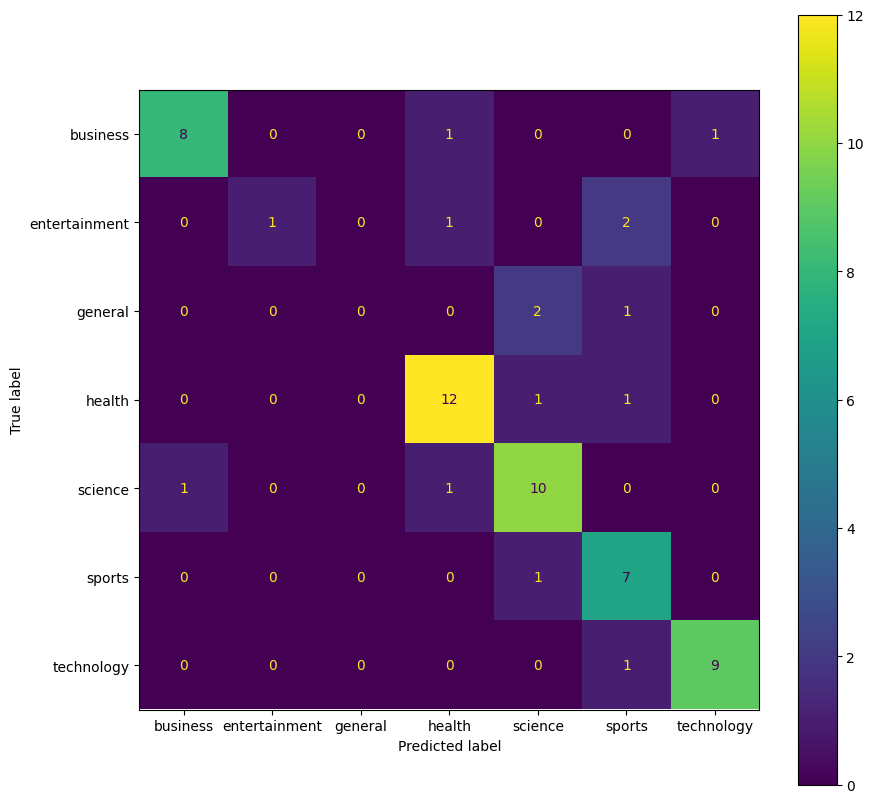

In [399]:
#no lemma
preprocessing = "lowering-number-punctuation-stopword"

# Lowering all words
df_train['clean_text'] = df_train['text'].str.lower()
df_test['clean_text'] = df_test['text'].str.lower()

# Remove number
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: remove_number(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: remove_number(text))

# Remove punctuation
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: remove_punctuation(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: remove_punctuation(text))

# Remove stopwords
df_train['clean_text'] = df_train['clean_text'].apply(lambda text: remove_stopwords(text))
df_test['clean_text'] = df_test['clean_text'].apply(lambda text: remove_stopwords(text))

# BoW
# Fit and transform the text data
bow_vectors = vectorizer.fit_transform(df_train['clean_text'])
# Convert the BOW vectors to a DataFrame
X_train = pd.DataFrame(bow_vectors.toarray(), columns=vectorizer.get_feature_names_out())
# Convert sentiment labels to numpy array
y_train = df_train['class']

# Fit and transform the text data
bow_vectors = vectorizer.transform(df_test['clean_text'])
# Convert the BOW vectors to a DataFrame
X_test = pd.DataFrame(bow_vectors.toarray(), columns=vectorizer.get_feature_names_out())
# Convert sentiment labels to numpy array
y_test = df_test['class']

mnb_model = MultinomialNB()
# Add the Multinomial Naive Bayes model to the model_map
model_map['multinomial-naive-bayes'] = mnb_model

train2_model('multinomial-naive-bayes', X_train, y_train)

model = mnb_model
y_pred_test = model.predict(X_test)

# Create Confusion Matrix
print("Test")
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot()

# Print Confusion Matrix
fig = disp.figure_
fig.set_figwidth(10)
fig.set_figheight(10)

In [400]:
def inference(model, text):
  # Lowering all words
  text = text.lower()
  # Remove number
  text = remove_number(text)
  # Remove punctuation
  text = remove_punctuation(text)
  # Remove stopwords
  text = remove_stopwords(text)

  # BoW
  # Fit and transform the text data
  bow_vectors = vectorizer.transform([text])
  # Convert the BOW vectors to a DataFrame
  X_test = pd.DataFrame(bow_vectors.toarray(), columns=vectorizer.get_feature_names_out())

  y_pred_test = model.predict(X_test)

  print(y_pred_test)

In [401]:
inference(mnb_model, "Apple launched new Mac Book")

['technology']


In [402]:
inference(mnb_model, "Cristiano Ronaldo scored hatrick at Anfield Stadium")

['sports']


In [403]:
inference(mnb_model, "Covid-19 vaccine have been supplied to Indonesia")

['health']
